<a href="https://colab.research.google.com/github/SJzamula/AI_Technology/blob/lab3/Zamula_Liubov_IP_04_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import heapq

На цьому етапі я додаю **add_road_sighns()** метод для моніторингу знаків, а також **add_intersection_info** та **get_intersection_info** для додавання знань про перехрестя.

Крім того, для того, щоб відслідкувати покращення роботи графа, я помічаю у роботі виведення графа відвідані перехрестя жовтим кольором.

In [33]:
class RoadGraph:
    def __init__(self, size):
        self.size = size
        self.G = self.generate_graph()
        self.road_signs = {}

    def generate_graph(self):
      G = nx.grid_2d_graph(self.size, self.size)
      return G

    def remove_random_edges(self, num_edges_to_remove):
      edges_removed = 0
      while edges_removed < num_edges_to_remove:
        edge = random.choice(list(self.G.edges))
        self.G.remove_edge(*edge)
        if nx.is_connected(self.G):
          edges_removed += 1
        else: self.G.add_edge(*edge)

    def add_road_signs(self):
      for node in self.G.nodes:
        connected_nodes = list(self.G.neighbors(node))
        self.road_signs[node] = connected_nodes
        print(f"Intersection {node} road signs: {connected_nodes}")  # Test print

    def add_intersection_info(self, intersection, info):
      self.road_signs[intersection] = info

    def get_intersection_info(self, intersection):
      return self.road_signs.get(intersection, None)

    def display_graph(self, path=None, visited=None):
      pos = {(x, y): (y, -x) for x, y in self.G.nodes}
      nx.draw(self.G, pos, with_labels=False, node_size=30, node_color='lightgray')

      if path:
        nx.draw(self.G, pos, with_labels=False, node_size=30, node_color='lightgray')
        path_edges = list(zip(path, path[1:]))

      if visited:
        nx.draw_networkx_nodes(self.G, pos, nodelist=visited, node_color='yellow', node_size=30)

      if path:
        nx.draw_networkx_edges(self.G, pos, edgelist=path_edges, edge_color='blue', width=2)
        nx.draw_networkx_nodes(self.G, pos, nodelist=path, node_color='blue', node_size=30)

        nx.draw_networkx_nodes(self.G, pos, nodelist=[path[0]], node_color='green', node_size=30)
        nx.draw_networkx_nodes(self.G, pos, nodelist=[path[-1]], node_color='red', node_size=30)

      else:
        nx.draw(self.G, pos, with_labels=False, node_size=30, node_color='lightgray')


      plt.axis('off')
      plt.show()


road = RoadGraph(10)
road.remove_random_edges(70)
road.add_road_signs()

#road.display_graph()

Intersection (0, 0) road signs: [(1, 0), (0, 1)]
Intersection (0, 1) road signs: [(1, 1), (0, 0), (0, 2)]
Intersection (0, 2) road signs: [(1, 2), (0, 1)]
Intersection (0, 3) road signs: [(0, 4)]
Intersection (0, 4) road signs: [(1, 4), (0, 3)]
Intersection (0, 5) road signs: [(1, 5), (0, 6)]
Intersection (0, 6) road signs: [(0, 5), (0, 7)]
Intersection (0, 7) road signs: [(1, 7), (0, 6)]
Intersection (0, 8) road signs: [(0, 9)]
Intersection (0, 9) road signs: [(1, 9), (0, 8)]
Intersection (1, 0) road signs: [(0, 0), (1, 1)]
Intersection (1, 1) road signs: [(0, 1), (2, 1), (1, 0), (1, 2)]
Intersection (1, 2) road signs: [(0, 2), (2, 2), (1, 1), (1, 3)]
Intersection (1, 3) road signs: [(2, 3), (1, 2), (1, 4)]
Intersection (1, 4) road signs: [(0, 4), (1, 3)]
Intersection (1, 5) road signs: [(0, 5), (1, 6)]
Intersection (1, 6) road signs: [(2, 6), (1, 5)]
Intersection (1, 7) road signs: [(0, 7), (1, 8)]
Intersection (1, 8) road signs: [(2, 8), (1, 7)]
Intersection (1, 9) road signs: [(0, 

Клас **RoadKnowlegeBase** для отримання та оновлення інформації про перехрестя.

In [34]:
class RoadKnowlegeBase:
  def __init__(self):
    self.road_info = {}

  def update_road(self, road, info):
    self.road_info[road] = info

  def get_road_info(self, road):
    return self.road_info.get(road, None)

В класі **CarAgent** додала 2 методи: **move_and_update_knowlege**, **is_valid_move**, а також модифікувала метод **find_route**.

**move_and_update_knowlege** метод дозволяє оновлювати базу даних для кожного перехрестя та переходити на нове.

**is_valid_move** перевіряє, чи в перехрестя наступного є якісь інші дороги, крім тієї, з якої ідеш. Якшо ні - то пропускається перехрестя  в **find_route**.

In [35]:
class CarAgent:
  def __init__(self, road, start, goal):
    self.road = road
    self.start = start
    self.goal = goal
    self.visited = set()
    self.visited_intersections = set()
    self.route = []
    self.came_from = {}
    self.knowlege_base = RoadKnowlegeBase()
    self.current_position = start

  def heuristic(self, a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

  def get_neighbors(self, node):
    return list(self.road.G.neighbors(node))

  def reconstruct_path(self, current):
    total_path = [current]
    while current in self.came_from:
      current = self.came_from[current]
      total_path.append(current)
    total_path.reverse()
    return total_path

  def move_and_update_knowlege(self, new_position):
    self.current_position = new_position
    intersection_info = self.road.get_intersection_info(new_position)
    self.knowlege_base.update_road(new_position, intersection_info)
    self.visited_intersections.add(new_position)

    print(f"At intersection {new_position}, road signs: {intersection_info}")

  def estimate_road_cost(self, from_node, to_node):
    road_info = self.knowlege_base.get_road_info((from_node, to_node))
    if road_info:
      if road_info.get('restriction', False):
        return float('inf')
      return road_info.get('cost', 1)
    return 1

  def is_valid_move(self, current, next_node):
    next_node_signs = self.road.get_intersection_info(next_node)
    if len(next_node_signs) == 1:
      return False
    return True

  def find_route(self):
    open_set = []
    heapq.heappush(open_set, (0, self.start))

    g_score = {node: float('inf') for node in self.road.G.nodes()}
    g_score[self.start] = 0

    f_score = {node: float('inf') for node in self.road.G.nodes()}
    f_score[self.start] = self.heuristic(self.start, self.goal)

    while open_set:
      current = heapq.heappop(open_set)[1]
      self.move_and_update_knowlege(current)

      if current == self.goal:
        self.route = self.reconstruct_path(current)
        return self.route

      self.visited.add(current)

      for neighbor in self.get_neighbors(current):
        if not self.is_valid_move(current, neighbor):
          continue

        tentative_g_score = g_score[current] + self.estimate_road_cost(current, neighbor)

        if tentative_g_score < g_score[neighbor]:
          self.came_from[neighbor] = current
          g_score[neighbor] = tentative_g_score
          f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, self.goal)

          if neighbor not in self.visited:
            heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return False

At intersection (1, 0), road signs: [(0, 0), (1, 1)]
At intersection (1, 1), road signs: [(0, 1), (2, 1), (1, 0), (1, 2)]
At intersection (1, 2), road signs: [(0, 2), (2, 2), (1, 1), (1, 3)]
At intersection (1, 3), road signs: [(2, 3), (1, 2), (1, 4)]
At intersection (1, 4), road signs: [(0, 4), (1, 3)]
At intersection (2, 1), road signs: [(1, 1), (2, 0), (2, 2)]
At intersection (2, 2), road signs: [(1, 2), (3, 2), (2, 1)]
At intersection (2, 3), road signs: [(1, 3), (2, 4)]
At intersection (2, 4), road signs: [(3, 4), (2, 3)]
At intersection (3, 2), road signs: [(2, 2), (4, 2), (3, 3)]
At intersection (3, 3), road signs: [(3, 2), (3, 4)]
At intersection (3, 4), road signs: [(2, 4), (3, 3)]
At intersection (4, 2), road signs: [(3, 2), (5, 2), (4, 3)]
At intersection (4, 3), road signs: [(5, 3), (4, 2), (4, 4)]
At intersection (5, 2), road signs: [(4, 2), (6, 2)]
At intersection (5, 3), road signs: [(4, 3), (6, 3)]
At intersection (6, 2), road signs: [(5, 2), (7, 2), (6, 1), (6, 3)]
At 

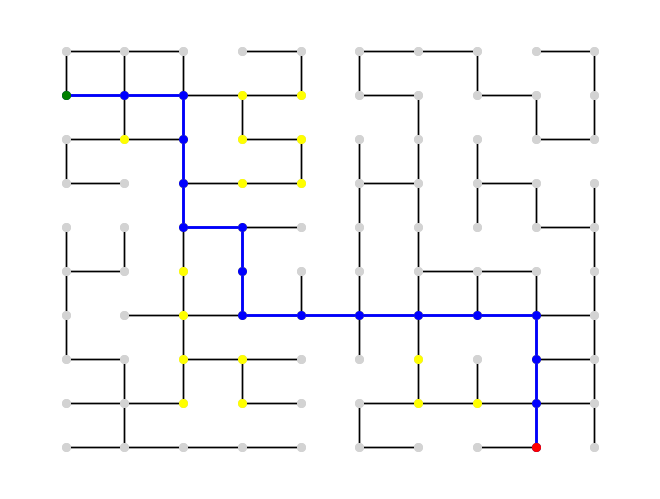

In [36]:
start_point = (1, 0)
goal_point = (9, 8)

agent = CarAgent(road, start_point, goal_point)
agent.find_route()

road.display_graph(agent.route, visited=agent.visited_intersections)